## RNN Precipitación Cerro Saroche

**PROYECTO:** SISTEMA PARA EL SEGUIMIENTO DE ECOSISTEMAS VENEZOLANOS \
**AUTOR:** Javier Martinez

Directorio de trabajo

In [1]:
import os

print('> Directorio actual: ', os.getcwd())  
os.chdir('../')
print('> Directorio actual: ', os.getcwd()) 

> Directorio actual:  /media/javier/Compartida/doctorado/ssev-analytics/cerro_saroche
> Directorio actual:  /media/javier/Compartida/doctorado/ssev-analytics


In [2]:
from utils.MONGO import CONEXION
from datetime import datetime
import pandas as pd
import numpy as np

from tensorflow import keras

from utils.UTILS import *

# Creando Coenxión con Mongo DB

In [3]:
# Creando la conexión con MongoDB
db = CONEXION.conexion()
db.list_collection_names()

['meteorological', 'estimateSSTNino34', 'SSTNino34']

# Descargando la Información Precipitación

In [4]:
# Parque
park = 'cerro_saroche'

# Realizando consulta
meteorological = db.meteorological.find({"park":park})

# Generando pandas dataframe
data_pandas = pd.DataFrame([file for file in meteorological])
data_pandas['periodo'] = data_pandas.time.apply(lambda x: datetime.fromordinal(x))
data_pandas['mes_year'] =  data_pandas['periodo'].dt.strftime('%B-%Y')
data_pandas.index = pd.to_datetime(data_pandas.periodo)
data_pandas.head()

,_id,id_point,park,time,elevacion_maxima,elevacion_media,elevacion_mediana,latitud,longitud,ndvi_maxima,ndvi_media,ndvi_mediana,precipitacion_mm,time_actualizacion,periodo,mes_year
periodo,,,,,,,,,,,,,,,,
1970-01-01,633988a2eed0e0231b327c97,1,cerro_saroche,719163,921.0,508.541046,491.0,10.31,-69.83,NaN,NaN,NaN,0.913065,738430,1970-01-01,January-1970
1970-01-01,633988a2eed0e0231b327ca7,2,cerro_saroche,719163,1000.0,625.942932,614.0,10.31,-69.73,NaN,NaN,NaN,0.958915,738430,1970-01-01,January-1970
1970-01-01,633988a2eed0e0231b327cc0,3,cerro_saroche,719163,1025.0,731.954834,731.0,10.31,-69.63,NaN,NaN,NaN,1.026073,738430,1970-01-01,January-1970
1970-01-01,633988a2eed0e0231b327ccc,4,cerro_saroche,719163,1103.0,761.129150,737.0,10.31,-69.53,NaN,NaN,NaN,1.095035,738430,1970-01-01,January-1970
1970-01-01,633988a3eed0e0231b327cdc,5,cerro_saroche,719163,1202.0,726.967285,709.0,10.31,-69.43,NaN,NaN,NaN,1.203287,738430,1970-01-01,January-1970


In [5]:
# Registros
print(data_pandas.shape)

(9435, 16)


In [6]:
# Data disponible
print(data_pandas.index.min())
print(data_pandas.index.max())

1970-01-01 00:00:00
2022-05-01 00:00:00


In [7]:
DIR = './cerro_saroche/'

In [8]:
# Cantidad de registros
park_points = data_pandas[[ 'id_point','latitud', 'longitud','precipitacion_mm']]\
                .groupby(['id_point','latitud', 'longitud'],as_index=False)\
                .count()

# Guardando resumen de experimentos
park_points.to_csv(DIR + 'summary/poinst.csv')
park_points

,id_point,latitud,longitud,precipitacion_mm
0,1,10.31,-69.83,629
1,2,10.31,-69.73,629
2,3,10.31,-69.63,629
3,4,10.31,-69.53,629
4,5,10.31,-69.43,629
5,6,10.21,-69.83,629
6,7,10.21,-69.73,629
7,8,10.21,-69.63,629
8,9,10.21,-69.53,629
9,10,10.21,-69.43,629


In [9]:
pd_precipitacion = data_pandas[['id_point', 'latitud', 'longitud',
                                'precipitacion_mm']]
pd_precipitacion.head()

,id_point,latitud,longitud,precipitacion_mm
periodo,,,,
1970-01-01,1,10.31,-69.83,0.913065
1970-01-01,2,10.31,-69.73,0.958915
1970-01-01,3,10.31,-69.63,1.026073
1970-01-01,4,10.31,-69.53,1.095035
1970-01-01,5,10.31,-69.43,1.203287


# Cargando data SST

In [10]:
# Realizando consulta
data_sst = db.estimateSSTNino34.find()

# Generando pandas dataframe
pd_sst = pd.DataFrame([file for file in data_sst])[['oni','time']]
pd_sst['periodo'] = pd_sst.time.apply(lambda x: datetime.fromordinal(x))
pd_sst.index = pd.to_datetime(pd_sst.periodo)
pd_sst

pd_sst.head()

,oni,time,periodo
periodo,,,
1950-01-01,-1.470000,711858,1950-01-01
1950-02-01,-1.336667,711889,1950-02-01
1950-03-01,-1.163333,711917,1950-03-01
1950-04-01,-1.180000,711948,1950-04-01
1950-05-01,-1.070000,711978,1950-05-01


In [11]:
oni_max = pd_sst.oni.max()
oni_min = pd_sst.oni.min()

pd_sst['oni'] = pd_sst['oni'].apply(lambda x: (x-oni_min)/(oni_max-oni_min))

# Integrando base de datos

In [12]:
# Entrenamiento
pd_model = pd.merge(pd_precipitacion.reset_index(drop=False),pd_sst[['oni']].reset_index(drop=False),
                    on=['periodo'],
                    how='left'
                    )

# Pronostico
pd_sst_pron = pd_sst[['periodo','oni']][pd_sst.periodo > pd_model.periodo.max()].copy()

In [13]:
pd_model[[ 'id_point','latitud', 'longitud','oni']]\
                .groupby(['id_point','latitud', 'longitud'],as_index=False)\
                .count()

,id_point,latitud,longitud,oni
0,1,10.31,-69.83,629
1,2,10.31,-69.73,629
2,3,10.31,-69.63,629
3,4,10.31,-69.53,629
4,5,10.31,-69.43,629
5,6,10.21,-69.83,629
6,7,10.21,-69.73,629
7,8,10.21,-69.63,629
8,9,10.21,-69.53,629
9,10,10.21,-69.43,629


# Ajustando modelo RNN

In [14]:
pd_model.head()

,periodo,id_point,latitud,longitud,precipitacion_mm,oni
0,1970-01-01,1,10.31,-69.83,0.913065,0.543835
1,1970-01-01,2,10.31,-69.73,0.958915,0.543835
2,1970-01-01,3,10.31,-69.63,1.026073,0.543835
3,1970-01-01,4,10.31,-69.53,1.095035,0.543835
4,1970-01-01,5,10.31,-69.43,1.203287,0.543835


In [15]:
id_point = 1
y_output = 'precip_t'
feature = 'oni'

prediction_order = 12 # rango de prediccion
auto_order = 5*12 # componente autoregresiva

In [16]:
# Data
data_pd = pd_model.query(f'id_point=={id_point}').copy()
data_pd.index = pd.to_datetime(data_pd.periodo)

# Transformacion
transformacion = LogMinimax.create( data_pd.precipitacion_mm.to_numpy() )
data_pd['precip_t'] = transformacion.transformacion()

data_pd = data_pd[[y_output,feature]].sort_index().copy()
data_pd.head()

,precip_t,oni
periodo,,
1970-01-01,0.609060,0.543835
1970-02-01,0.167493,0.506771
1970-03-01,0.464581,0.497505
1970-04-01,0.605545,0.476123
1970-05-01,0.820615,0.444048


Redefiniendo serie temporal

In [17]:
x_data = []
y_data = []

for t in range(auto_order+1, data_pd.shape[0]+1):
    x_data.append( np.array(data_pd[(t-auto_order-1):(t-1)]) )
    y_data.append( np.array( data_pd[(t-auto_order-1):t][[y_output]] )[-1] )

In [18]:
x_data = np.array(x_data)
y_data = np.array(y_data).reshape(x_data.shape[0],1,1)

Entrenamiento y validación

In [19]:
x_train = x_data[:-prediction_order]
x_vasl = x_data[-prediction_order:]

y_train = y_data[:-prediction_order]
y_vasl = y_data[-prediction_order:]

print(x_train.shape)
print(x_vasl.shape)

print(y_train.shape)
print(y_vasl.shape)

(557, 60, 2)
(12, 60, 2)
(557, 1, 1)
(12, 1, 1)


Modelos RNN

In [20]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [21]:
# Metrícas
mae = keras.metrics.MeanAbsoluteError()
rmse = keras.metrics.RootMeanSquaredError()

In [22]:
model = keras.models.Sequential()

model.add(keras.layers.LSTM(auto_order, return_sequences=False ))

model.add(keras.layers.Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=[mae,rmse]) 

In [23]:
callback = keras.callbacks.EarlyStopping(
                                            monitor="loss",
                                            min_delta=0,
                                            patience=10,
                                            verbose=0,
                                            mode="min",
                                            baseline=None,
                                            restore_best_weights=False,
                                        )

Entrenamiento

In [24]:
epochs=500

history = model.fit(x=x_train,
                    y=y_train,
                    epochs=epochs,
                    batch_size=1,
                    verbose=0,
                    workers=2,
                    callbacks=[callback])

In [25]:
print(f'Total epocas:{len(history.epoch)}')

Total epocas:258


Evaluación

In [26]:
# make predictions
trainPredict = model.predict(x_train, verbose=0).reshape(-1)
testPredict = model.predict(x_vasl, verbose=0).reshape(-1)

In [27]:
# Data de test
trainind_pd = pd.DataFrame(trainPredict,
                            index = data_pd.index[:-prediction_order][-len(trainPredict):],
                            columns=['prediction']
                            )

trainind_pd[y_output] = y_train.reshape(-1)
trainind_pd['type'] = 'training'
trainind_pd['precipitacion_mm'] = trainind_pd[y_output].apply(lambda x: transformacion.inversa(x) if np.isnan(x)==False else np.nan )
trainind_pd['prediction_precipitacion_mm'] = trainind_pd['prediction'].apply(lambda x: transformacion.inversa(x) if np.isnan(x)==False else np.nan )

trainind_pd.head()

,prediction,precip_t,type,precipitacion_mm,prediction_precipitacion_mm
periodo,,,,,
1975-01-01,0.330511,0.317955,training,0.185326,0.198522
1975-02-01,0.320815,0.330354,training,0.198352,0.188253
1975-03-01,0.493215,0.486129,training,0.465626,0.484057
1975-04-01,0.542715,0.560596,training,0.700167,0.634834
1975-05-01,0.820116,0.807183,training,2.703042,2.901502


In [28]:
trainig_metrics = metrics(observado=trainind_pd.precipitacion_mm,prediccion=trainind_pd.prediction_precipitacion_mm)
trainig_metrics

{'mape': 13.177586013415423,
 'mae': 0.16018177406438563,
 'mse': 0.2737145939922991,
 'rmse': 0.07491967896436912,
 'r2': 0.9596756489419166}

In [29]:
# Data de Validacion
validation_pd = pd.DataFrame(testPredict,
                            index = data_pd.index[-prediction_order:],
                            columns=['prediction']
                            )

validation_pd[y_output] = y_vasl.reshape(-1)
validation_pd['type'] = 'validation'

validation_pd['precipitacion_mm'] = validation_pd[y_output].apply(lambda x: transformacion.inversa(x) if np.isnan(x)==False else np.nan )
validation_pd['prediction_precipitacion_mm'] = validation_pd['prediction'].apply(lambda x: transformacion.inversa(x) if np.isnan(x)==False else np.nan )
validation_pd.head()

,prediction,precip_t,type,precipitacion_mm,prediction_precipitacion_mm
periodo,,,,,
2021-06-01,0.543392,0.763679,validation,2.129873,0.637193
2021-07-01,0.491767,0.566845,validation,0.724552,0.480231
2021-08-01,0.559617,0.660034,validation,1.207184,0.696423
2021-09-01,0.551974,0.582156,validation,0.787944,0.667866
2021-10-01,0.819423,0.717919,validation,1.657627,2.890501


In [30]:
test_metrics = metrics(observado=validation_pd.precipitacion_mm,prediccion=validation_pd.prediction_precipitacion_mm)
test_metrics

{'mape': 251.34995064965665,
 'mae': 1.3634480384071475,
 'mse': 2.2278195006886863,
 'rmse': 4.963179727648787,
 'r2': -4.3132077109530575}

<AxesSubplot:xlabel='periodo'>

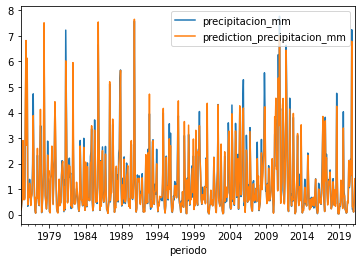

In [34]:
trainind_pd[['precipitacion_mm','prediction_precipitacion_mm']].plot()

<AxesSubplot:xlabel='periodo'>

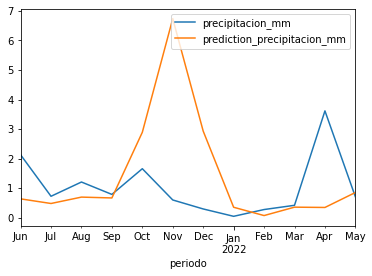

In [31]:
validation_pd[['precipitacion_mm','prediction_precipitacion_mm']].plot()